<a href="https://colab.research.google.com/github/wgrgwrght/Simple-Diffusion/blob/main/SimpleDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How to create a simple image in "T" easy steps using diffusion models

"Creating noise from data is easy; creating data from noise is generative modeling." (opening line in [1]). Wouldn't it be great if we could use neural networks to learn the noise in a given sample? This is what diffusion models do!


Imagine a black box that takes in random noise and "generates" samples from an underlying distribution. 

Let's consider a very simple image. It can either be a light colour, or a dark colour with has a small amount of variation and is has a probability of being dark of 0.3. We can describe the underlying probability distribution for this generative process (choosing a pixel colour) as $p(x)$ where $x\in \{Dark=N(200,5), Light=N(50,5)\}$ is sampled from $p(x)$, i.e., $x\backsim p(x)$. We would like to use a Diffusion Model to model this process using a number of data samples or observations from the original process for training. 

Specifically, we would like to train a generative process such that can generate a series of pixels whose probability distribution matches the distribution described above, i.e., $P(Dark)=0.3, P(Light)=0.7$.

In more mathematical terms, we would like to obtain a generative process $x=G(z;\theta)$ that can generate samples $x$ using Normally distributed random input ($z\backsim N(0,1)$) such that the probability distribution of these generated samples $p_G(x)$ is close to $p(x)$ without knowing $p(x)$ in advance or explicitly modelling $p_G(x)$. 

Using a generative diffusion model is an overkill for this simple task and there are much simpler and more effective ways of modelling this simple problem (e.g., inverse sampling: https://en.wikipedia.org/wiki/Inverse_transform_sampling or rejection sampling: https://en.wikipedia.org/wiki/Rejection_sampling). However, this solution is intended to help you understand how Diffusion models can model complex densities implicitly and can be used to generate samples that mimic the true or natural generative process. The bigger goal is cover the mechanics of the diffusion process as well as the intuition behind it. 


We first simulate the pixel values and generate 30,000 training samples below. The histogram shows the (sample estimate of) the true density. 

device cpu


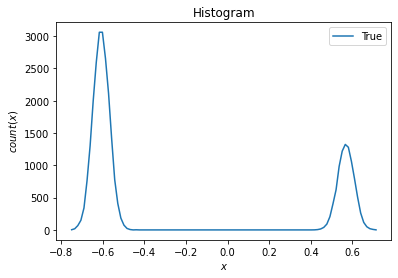

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch, torchvision
from torch import nn
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device {device}')

# generate samples around 50 and 200 with std 5
light = np.random.normal(loc=50, scale=5.0, size=21000)
dark = np.random.normal(loc=200, scale=5.0, size=9000)

# Convert numbers to range [1,-1] and in correct format for model
light = [[torch.tensor((a/127.5)-1).float()] for a in light]
dark = [[torch.tensor((a/127.5)-1).float()] for a in dark]
dataset = torch.tensor(dark + light)

train_input = dataset.to(device)

#show histogram of distribution
hist, bins = np.histogram(dataset, bins=100)
bin_centers = (bins[1:]+bins[:-1])*0.5
plt.plot(bin_centers, hist, label="True")
plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
plt.show()

The goal is to use Normally distributed Random Noise $z\backsim N(0,1)$ as input to generate $x\backsim p(x)$. A diffusion model achieves this by using a fixed "forward process" (not to be confused with the forward function of neural networks) in which we add increasing amounts of random noise to input (training) sample. The forward process is essentially a chain that generates a noisy sample $x_t=q(x_t|x_{t-1})$ by adding noise to the sample $x_{t-1}$ for different time steps $t = 1\ldots T$ with $x_0 = x$ (input sample). Note that the chain is "Markov" as the current step is only dependent upon the previous one (and the added noise). 

As discussed above, the noise is increased over time. The procedure by which the noise is increased is called the schedule. Formally, the forward process can be written as: $q(x_t|x_{t-1})=N(\sqrt{1-\beta_t} x_{t-1},\beta_t I)$ where $\beta_t \in (0,1)$ is the variance of the Gaussian Noise which is increased over time steps. The key assumption is that the noise schedule adds noise to $x$ "slowly" so that  the distribution of the data with noise at in the beginning is almost the same as the original data distribution, i.e., $(p_{t=1}(x)  \approx p(x))$. However, after "sufficient" time steps, the sample is esssentially isotropic Gaussian noise $(p_{t=T}(x)  \approx N(0,I))$. 

As the noise in each step is Gaussian and it gets summed over time, the overall effect can be modelled as addition of a Gaussian noise (with a variance dependent upon $t$) to the input sample. As a consequence, we do not need to generate samples in a painstaking step-wise manner. Without worrying about the proof, we can simply say that, we can generate $x_t$ from $x_0$ for any $t$ using the expression below:

$q(x_t|x_0)=N(\sqrt{\hat{\alpha_t}}x_0,(1-\hat{\alpha_t}) I)$

where $\hat{\alpha_t}=\prod_{j=0}^{t}\alpha_t$ and $\alpha_t = 1-\beta_t$. 

Or more simply: 

$x_t = \sqrt{\hat{\alpha_t}}x_0+\sqrt{1-\hat{\alpha_t}}\epsilon$ for $\epsilon\backsim N(0,I)$. 

Thus, the noise added to $x_0$ is simply $\epsilon_t = x_t-x_0 $. 

Below we precompute the values for each timestep and show how the distribution changes from the histogram above into $N(0,I)$ at timestep T using a violin plot. This is the training data which will be used in the model.

In [ ]:
# create variance schedule
T = 50
beta = torch.linspace(1e-4, 0.02, T, device = device)

# precompute values for schedule
alpha = 1 - beta
alpha_bar = alpha.log().cumsum(0).exp()
sigma = beta.sqrt()
sqrt_recip_alpha = torch.sqrt(1.0 / alpha)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1. - alpha_bar)

In [ ]:
""" 
Takes an image and a timestep as input and 

returns the noisy version of it
"""
def forward_diffusion_sample(x_0, t, device="cpu"):

    # define noise to add
    noise = torch.randn_like(x_0)
    
    # add noise to data as per formula
    mean = sqrt_alpha_bar[t].to(device) * x_0.to(device)
    variance = sqrt_one_minus_alpha_bar[t].to(device) * noise.to(device)
    
    return mean + variance, noise.to(device)

In [ ]:
"""
Data as input

Returns timesteps showing forward noise diffusion
"""

def show_noise(data, min_num_steps):
    # initialise return lists
    timesteps = []
    labels = []
    
    # choose timesteps to record
    stepsize = int(T/(min_num_steps-1))
    steps = list(range(0, T, stepsize))
    steps.append(T-1)
    
    for t in steps:
        
        # get noisy version of data
        data_t, noise = forward_diffusion_sample(data, t, device=device)
        
        #append to list in list format for plotting
        timesteps.append([instance[0] for instance in data_t.tolist()])
        labels.append(t)
        
    return timesteps, labels


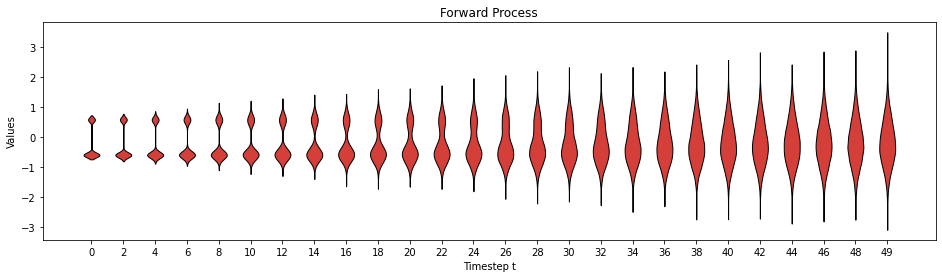

In [ ]:
# plot forward process

ts, ls = show_noise(dataset, 20)

fig, ax = plt.subplots(nrows=1, figsize=(16, 4), sharey=True)

parts = ax.violinplot(ts, showmeans=False, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

ax.set_xticks(np.arange(1, len(ls) + 1))
ax.set_xticklabels(ls)
ax.set_title('Forward Process')
ax.set_ylabel('Values')
ax.set_xlabel('Timestep t')

plt.show()

We now want to learn to be able to reverse this process, start with noise and go to our original distribution.

This can be done using a neural network $\epsilon_\theta (x_t,t) $ with weights $\theta$ which takes the noisy input $x_t$ as input along with the time step $t$ (and possibly other "conditioning" variables) to output an estimate of the noise $\epsilon_t$ that has been added to $x_0$ to generate $x_t$. This is achieved by solving the following optimization problem:

$min_\theta \mathbb E_{t,x_0,\epsilon} |\epsilon_t-\epsilon_\theta (x_t,t)|^2$

Note that we are learning the noise which when subtracted from a noisy sample will yield the original datum. 

Also note that there is an "expectation" in the objective function which can be approximated by picking a sample from the training set, randomly generating a time step $t$ and obtaining $x_t$ by adding noise through the "forward process" and then using that as input to the neural network. 

There is a theoretical proof which essentially says that minimization of the objective function is (roughly) equivalent to minimization of the evidence lower bound (ELBO) of the KL-divergence between the true probability distribution $p(x)$ and the probability distribution learned by the generative process. 

Below the model is defined as a multilayer perceptron although for more complicated problems other networks (such as U-Nets) can be used. The only restriction in architecture for diffusion models is that the output noise estimation must be the same size as the input data.

In [ ]:
# Gets a pair (x, t) and appends t (scalar or 1d tensor) to x as an
# additional dimension / channel

class TimeAppender(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, u):
        x, t = u
        if not torch.is_tensor(t):
            t = x.new_full((x.size(0),), t)
        t = t.view((-1,) + (1,) * (x.dim() - 1)).expand_as(x[:,:1])
        return torch.cat((x, t), 1)

In [ ]:
# Define Model

nh = 256

model = nn.Sequential(
    TimeAppender(),
    nn.Linear(train_input.size(1) + 1, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, train_input.size(1)),
)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

model.to(device)

print(f'nb_parameters {sum([ p.numel() for p in model.parameters() ])}')

model.eval()

nb_parameters 132609


Sequential(
  (0): TimeAppender()
  (1): Linear(in_features=2, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
# train model
epochs = 100
batch_size = 2048

for k in range(epochs):

    epoch_loss = 0

    for x0 in train_input.split(batch_size):
        
        # pick random timestep t
        t = torch.randint(T, (x0.size(0),) + (1,) * (x0.dim() - 1), device = x0.device)
        
        # adds noise at t
        noise = torch.randn_like(x0)
        xt = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * noise
        
        # model predicts the noise
        noise_pred = model((xt, t / (T - 1) - 0.5))
        
        # loss function 
        loss = F.mse_loss(noise, noise_pred)
        epoch_loss += loss.item() * x0.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'{k} {epoch_loss / train_input.size(0)}')


0 0.9554781450589498
1 0.8353969310442607
2 0.7670390551249187
3 0.7253841586748759
4 0.6724316608428955
5 0.6463643143971761
6 0.6186213610649108
7 0.599393964211146
8 0.5758274356683095
9 0.5537918208916982
10 0.5541083231767019
11 0.5498626426537832
12 0.523057308292389
13 0.5248974488576253
14 0.5082835912386576
15 0.5031561427434286
16 0.5007632026195526
17 0.49155255319277447
18 0.48557702237764994
19 0.4715586465835571
20 0.47050063846906026
21 0.46559171223640444
22 0.46075193049112956
23 0.44974356961250306
24 0.4648704424540202
25 0.44987733499209087
26 0.43256858153343203
27 0.42901430033842725
28 0.4266019178549449
29 0.4227011520862579
30 0.40778952309290567
31 0.4199910883108775
32 0.4211710488319397
33 0.4180573142369588
34 0.39874787928263344
35 0.41277236604690554
36 0.39719565645853677
37 0.39949577333927155
38 0.3912392908414205
39 0.39216934146881105
40 0.3791518053372701
41 0.38976474787394205
42 0.37867938334147133
43 0.38235486772060395
44 0.37351186951001486
45 

Now the neural network is trained to predict the noise at a timestep: 

1. We can, given a noisy estimate at a given time step, generate an approximation of $x$ as $x_t' = x_t - \epsilon_\theta (x_t,t)$, i.e., achieve "Denoising". 

2. We can start off with random noise $x_T = N(0,I)$ and generate a sample: $x_T' = x_T-\epsilon_\theta (x_T,T)$. However, as there is a large jump from $x_T$ to $x_0$, we do this in a step-wise manner. We can find a sample at the next timestep using the formula $x_{t-1} = \frac{1}{\sqrt{α_t}}(x_t - \frac{1-α_t}{\sqrt{1-ᾱ_t}} \epsilon_\theta (x_t,t)) + \sqrt{β_t} z$ where $z \backsim N(0,I)$ if $t > 1$ else $z=0$. 

So taking noise, and iterating through all timesteps, this algorithm can reverse the forward diffusion process and denoise to take us to the original distribution! 

Below we define a function which does just that using the model created above. We create 10,000 samples and plot the distribution for intermediate timesteps showing this reverse process. 




In [ ]:
# function to generate a sample from noise

def generate(size, min_num_image):

    with torch.no_grad():
        
        ts = []
        ls = []
        
        # start with noise at x_T
        x_T = torch.randn(size, device = device)

        # go through all timesteps t back to x_0
        for t in range(T-1, -1, -1):
            
            # model noise prediction
            output = model((x_T, t / (T - 1) - 0.5))
            
            # formula to get timestep x_(t-1)
            z = torch.zeros_like(x_T) if t == 0 else torch.randn_like(x_T)
            x_T = 1/torch.sqrt(alpha[t]) \
                * (x_T - (1-alpha[t]) / torch.sqrt(1-alpha_bar[t]) * output) \
                + sigma[t] * z
            
            # add first timestep to return list
            if t == (T-1):
                ts.append([a[0] for a in x_T.tolist()])
                ls.append(T-1)
            
            # add to list of timesteps for plotting
            if t % int(T/(min_num_image-1)) == 0:
                ts.append([a[0] for a in x_T.tolist()])
                ls.append(t)

        return x_T, ts, ls

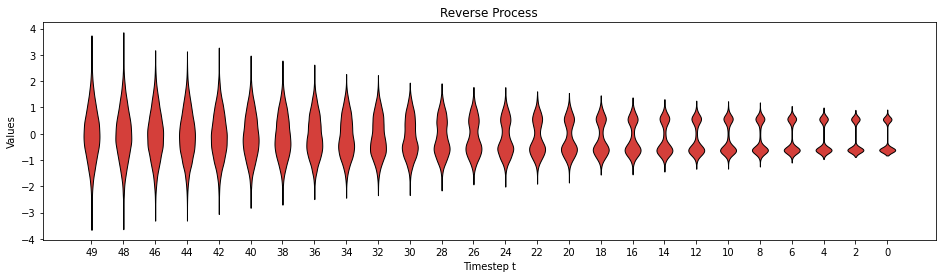

In [ ]:
# generate 10,000 samples & plot reverse process
x_0, ts, ls = generate((10000, 1), 20)

fig, ax = plt.subplots(nrows=1, figsize=(16, 4), sharey=True)

parts = ax.violinplot(ts, showmeans=False, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

ax.set_xticks(np.arange(1, len(ls) + 1))
ax.set_xticklabels(ls)
ax.set_title('Reverse Process')
ax.set_ylabel('Values')
ax.set_xlabel('Timestep t')

plt.show()

So using this method we can produce images which are either light or dark with the same probability as the original training data.

Comparing the original distribution to the generated samples using a histogram shows the accuracy of the model in generating samples.

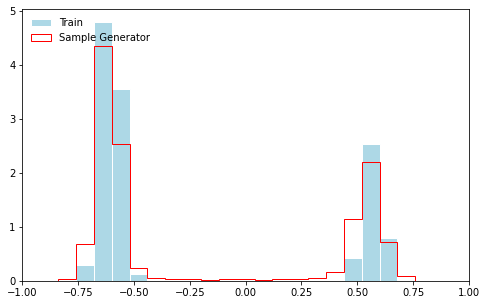

In [ ]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(8)

ax = fig.add_subplot(1, 1, 1)

x_0, ts, ls = generate((10000, 1), 20)

ax.set_xlim(-1.0, 1.0)


d = train_input.flatten().detach().to('cpu').numpy()
ax.hist(d, 25, (-1, 1),
        density = True,
        histtype = 'bar', edgecolor = 'white', color = 'lightblue', label = 'Train')

d = x_0.flatten().detach().to('cpu').numpy()
ax.hist(d, 25, (-1, 1),
        density = True,
        histtype = 'step', color = 'red', label = 'Sample Generator')

ax.legend(frameon = False, loc = 2)

if hasattr(plt.get_current_fig_manager(), 'window'):
    plt.get_current_fig_manager().window.setGeometry(2, 2, 1024, 768)
    plt.show()


This is a very simple model which can create single values however, the same principle applies to higher dimensional data. For example this can be utilised to create images[2] and has gained a lot of recent publicity in high quality image generation from a text prompts (such as DALL-E [4] and Stable Diffusion[5]) but for this we need to modify the above process. 

Conditional Generation: Diffusion models can also be used to generate samples conditioned on a given input $y$ (e.g., embedding of a text prompt). One way is to use Classifier Guided Sampling: Assume that you have a discriminative predictior $p(y|x)$, then we can use the trained model to guide the sampling (Classifier Guided Sampling) which works by directing the generative process towards the probability mass of samples for that class as learned by the discriminative model. This works as follows:

Input: class label  $y$

$x_0$ sampled from $N(0,I)$

For $t = T\ldots 1$:

Calculate the "score" of the trained predictor (i.e., derivative of the log conditional probability density of the trained discriminative model with respect to the input): $g = s \nabla_{x_t} log \ p(y|x_t)$ 

Generate $x_{t-1}$ using  $x_t+g$ as input to the generative process

End-For

Note that this way requires two models but the generative model $\epsilon_\theta (x_t,t)$ is independent of any specific class distribution and can thus be trained without class labels. The labels are only needed for the discriminative model. Thus the model can be used to generated objects of different classes in a "post-hoc" manner.  

This is somewhat similar to a GAN in which we have a discriminative model which, unlike this predictive model that generates class probabilities, predicts whether a given sample is fake or real and uses the gradient of the loss of the disctiminative model to guide the generation process.

However, there is an easier alternative in which the neural network takes $y$ as an additional input to generate the noise $\epsilon_\theta (x_t,t,y)$ and then the generative process is gradually forced towards $\epsilon_\theta (x_t,t,y)$ for a given label $y$ and away from $\epsilon_\theta (x_t,t,\phi)$ where $\phi$ is the null input. Note that this requires class labels for the conditioning in training as well. 


**Acknowledgements**


[1] Song, Yang, Jascha Sohl-Dickstein, Diederik P. Kingma, Abhishek Kumar, Stefano Ermon, and Ben Poole. “Score-Based Generative Modeling through Stochastic Differential Equations.” arXiv, February 10, 2021. https://doi.org/10.48550/arXiv.2011.13456.

[2] Hugging Face. "The Annotated Diffusion Model" https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=a30368b2

[3] Francois Fleuret https://twitter.com/francoisfleuret/status/1558733449481027585?t=pn9I7NopfXFu2pkQAdWEuA&s=19

[4] OpenAI. DALL.E 2, 2022. https://openai.com/dall-e-2/ (accessed October 2022)

[5] Stability AI. "Stable Diffusion Public Release", 2022 https://stability.ai/blog/stable-diffusion-public-release (accessed October 2022)